<a href="https://colab.research.google.com/github/shreya-kamra/Breast-Cancer-Classification-based-on-Hybrid-Learning-using-Texture-Features-of-Ultrasound-Images/blob/main/resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow import keras
import cv2
from tensorflow.keras.preprocessing.image import load_img ,img_to_array
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,AveragePooling2D,BatchNormalization
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.layers import Flatten,Dropout,SpatialDropout2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
import os
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Dataset_BUSI_with_GT"
dir_list = [os.path.join(path,i) for i in os.listdir(path)]
size_dict = {}
for i,value in enumerate(dir_list):
    size_dict[os.listdir(path)[i]] = len(os.listdir(value))
size_dict

{'benign': 891, 'normal': 266, 'malignant': 421}

In [ ]:
import re
def clean(name):
    name = re.sub('[benign ().p]','',str(name))
    return name

In [ ]:
df = pd.DataFrame(os.listdir(dir_list[0]))
df = df[0].apply(clean)
df = df[~df.str.contains('mask',regex =False)]
df = pd.to_numeric(df, errors='coerce')
df_list = list(df)
type(df_list)
df_list.sort()
print(len(df_list))

437


In [ ]:
img_size = 128
img_channel = 3
X_b , Xm_b , y_b = np.zeros((437,img_size,img_size,img_channel)) , np.zeros((437,img_size,img_size,img_channel)) , np.full(437,'benign')
X_n , Xm_n , y_n = np.zeros((133,img_size,img_size,img_channel)) , np.zeros((133,img_size,img_size,img_channel)) , np.full(133,'normal')
X_m , Xm_m , y_m = np.zeros((210,img_size,img_size,img_channel)) , np.zeros((210,img_size,img_size,img_channel)) , np.full(210,'malignant')

In [ ]:
import os
img1_path = os.path.join(os.path.join(path,'benign'),os.listdir(os.path.join(path,'benign'))[1])

pil_img = load_img(img1_path,color_mode = 'rgb',target_size=(img_size,img_size))
img = img_to_array(pil_img)
img_shape = img.shape
print(img_shape)

def img_num(filename):

    val = 0

    for i in range(len(filename)) :
        if filename[i] == '(' :
            while True :
                i += 1
                if filename[i] == ')' :
                    break
                val = (val*10) + int(filename[i])
            break

    return val

for tumor_path in dir_list :
    for image in os.listdir(tumor_path) :
        p = os.path.join(tumor_path, image)
        pil_img = load_img(p,color_mode = 'rgb',target_size=(img_size,img_size))         # read image as  grayscale and resize it

        if image[-5] == ')' :                                   #if real image

            if image[0] == 'b' :
                X_b[img_num(image)-1]+= img_to_array(pil_img)  # If image is real add it
            if image[0] == 'n' :                               # to X as benign , normal
                X_n[img_num(image)-1]+= img_to_array(pil_img)  # or malignant.
            if image[0] == 'm' :
                X_m[img_num(image)-1]+= img_to_array(pil_img)
        else :                                                 #else masked image

            if image[0] == 'b' :
                Xm_b[img_num(image)-1]+= img_to_array(pil_img)  # Similarly add the target
            if image[0] == 'n' :                               # mask to y.
                Xm_n[img_num(image)-1]+= img_to_array(pil_img)
            if image[0] == 'm' :
                Xm_m[img_num(image)-1]+= img_to_array(pil_img)

(128, 128, 3)


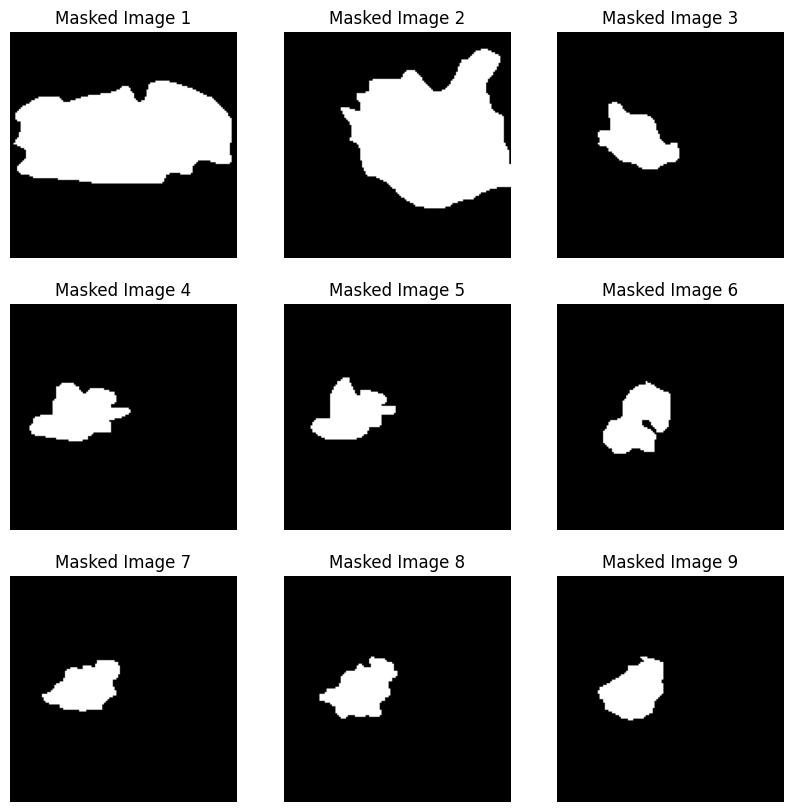

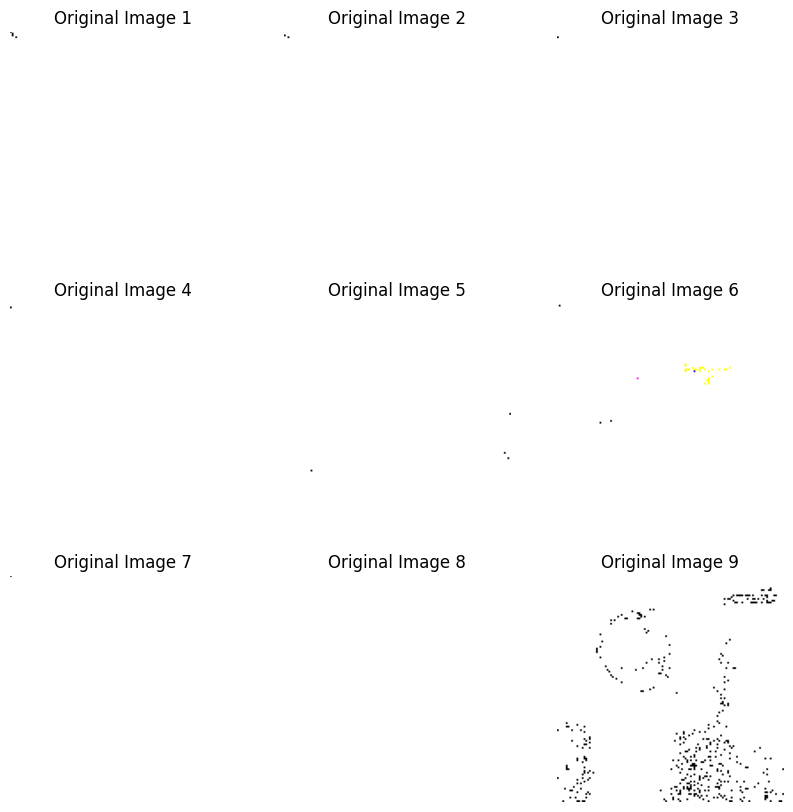

In [ ]:
import matplotlib.pyplot as plt

def display_images(images, title):
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Displaying 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f'{title} Image {i+1}')
        plt.axis('off')
    plt.show()

# Display some images from X (masked images)
display_images(Xm_m, 'Masked')

# Display some images from X (original images)
display_images(X_b, 'Original')


In [ ]:
X = np.concatenate((X_b, X_n, X_m), axis = 0)
Xm = np.concatenate((Xm_b, Xm_n, Xm_m), axis = 0)
y = np.concatenate((y_b, y_n, y_m), axis = 0)

print(X.shape)
print(Xm.shape)
print(y.shape)
X /= 255.0
Xm /= 255.0

print(X.max())
print(Xm.min())

(780, 128, 128, 3)
(780, 128, 128, 3)
(780,)
1.0
0.0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

encoder  = OneHotEncoder()
y = encoder.fit_transform(y.reshape(-1, 1)).toarray()



In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.15,shuffle=True,random_state=42)
Xm_train,Xm_test,ym_train,ym_test = train_test_split(Xm,y,test_size = 0.15,shuffle=True,random_state=42,stratify=y)

class_list = encoder.categories_
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(663, 128, 128, 3) (117, 128, 128, 3)
(663, 3) (117, 3)


In [ ]:
import tensorflow as tf
base_model = tf.keras.applications.ResNet50(
                include_top=False,
                weights="imagenet",
                input_tensor=None,
                input_shape=img_shape,
                pooling=None,
            )
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])


# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/30
21/21 [==============================] - 14s 194ms/step - loss: 0.9812 - acc: 0.5113 - val_loss: 2.6478 - val_acc: 0.4957
Epoch 2/30
21/21 [==============================] - 1s 45ms/step - loss: 0.8622 - acc: 0.6124 - val_loss: 3.0604 - val_acc: 0.4957
Epoch 3/30
21/21 [==============================] - 1s 45ms/step - loss: 0.7886 - acc: 0.6456 - val_loss: 3.0829 - val_acc: 0.4957
Epoch 4/30
21/21 [==============================] - 1s 45ms/step - loss: 0.7336 - acc: 0.6727 - val_loss: 3.4315 - val_acc: 0.4957
Epoch 5/30
21/21 [==============================] - 1s 44ms/step - loss: 0.7210 - acc: 0.6848 - val_loss: 3.5449 - val_acc: 0.4957
Epoch 6/30
21/21 [==============================] - 1s 47ms/step - loss: 0.6774 - acc: 0.7044 - val_loss: 3.3301 - val_acc: 0.4957
Epoch 7/30
21/21 [==============================] - 1s 56ms/step - loss: 0.6700 - acc: 0.7089 - val_loss: 3.0245 - val_acc: 0.4957
Epoch 8/30
21/21

In [ ]:
history = model.fit(Xm_train, ym_train, epochs=30, batch_size=32, validation_data=(Xm_test, ym_test))

loss, accuracy = model.evaluate(Xm_test, ym_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/30
21/21 [==============================] - 1s 53ms/step - loss: 0.0569 - acc: 0.9834 - val_loss: 0.3304 - val_acc: 0.9658
Epoch 2/30
21/21 [==============================] - 1s 46ms/step - loss: 0.0263 - acc: 0.9940 - val_loss: 0.3586 - val_acc: 0.9231
Epoch 3/30
21/21 [==============================] - 1s 48ms/step - loss: 0.0457 - acc: 0.9879 - val_loss: 0.3320 - val_acc: 0.9658
Epoch 4/30
21/21 [==============================] - 1s 49ms/step - loss: 0.0309 - acc: 0.9879 - val_loss: 0.3381 - val_acc: 0.9316
Epoch 5/30
21/21 [==============================] - 1s 47ms/step - loss: 0.0548 - acc: 0.9864 - val_loss: 0.3047 - val_acc: 0.9573
Epoch 6/30
21/21 [==============================] - 1s 46ms/step - loss: 0.0312 - acc: 0.9894 - val_loss: 0.3342 - val_acc: 0.9231
Epoch 7/30
21/21 [==============================] - 1s 45ms/step - loss: 0.0308 - acc: 0.9894 - val_loss: 0.4456 - val_acc: 0.8974
Epoch 8/30
21/21 [==============================] - 1s 46ms/step - loss: 0.0372 - a